# Imports

In [ ]:
!pip install patchify

In [ ]:
# from keras.utils.np_utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob
from skimage.morphology import medial_axis
from skimage import img_as_ubyte
from  scipy import ndimage
from keras.models import load_model
from skimage.morphology import medial_axis, label
import math
from skimage.measure import label, regionprops
import random
from skimage.transform import resize
from patchify import patchify, unpatchify
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Crack measurement function

In [ ]:
from skimage.morphology import skeletonize

def calculate_euclidean_distance(p1,p2):
  s1 = (math.pow(p1[0] - p2[0],2))
  s2 = (math.pow(p1[1] - p2[1],2))
  euclidean_distance = math.sqrt(s1+s2)
  return euclidean_distance


def get_boundary(numpy_img, pixel_value):
  canny_Img = cv2.Canny(numpy_img,100,200)
  contours,_ = cv2.findContours(canny_Img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  canvas = np.zeros_like(numpy_img)
  boundary = cv2.drawContours(canvas , contours, -1, pixel_value, 1)
  return boundary

# crack instance segment
def instance_segment(np_image):
  # get crack
  # im_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  rgb_original = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  if len(np.unique(np_image)) == 1:
    return np_image, 0

  labeled = label(np_image, background=0)
  pixel_values = np.unique(labeled)
  cracks = [np.where(labeled != label, 0, labeled) for label in pixel_values]
  del cracks[0]
  return cracks

def filter_crack_instances(cracks, np_image, delta):

  instances = []
  for crack_instance in cracks:
      im = crack_instance.astype(np.uint8) * 255
      rgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
      _, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)

      # get medial axis
      med_plot = np.zeros((256,256), np.uint8)
      medial, distance = medial_axis(im, return_distance=True)
      med_img = img_as_ubyte(medial)
      med_contours, _ = cv2.findContours(med_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      cv2.drawContours(med_plot, med_contours, -1, (255, 0, 0), 1)
      med_pts = [v[0] for v in med_contours[0]]

      # get point with maximal distance from medial axis
      max_idx = np.argmax(distance)
      max_pos = np.unravel_index(max_idx, distance.shape)
      max_dist = distance[max_pos]
      coords = np.array([max_pos[1], max_pos[0]])
      # print(f"max distance from medial axis to boundary = {max_dist} at x,y: {coords}")

      border_values = {0, 256}
      if coords[1] in border_values or coords[0] in border_values:
        continue

      # interpolate orthogonal of medial axis at coords
      # delta = 200
      try:
          idx = next(i for i, v in enumerate(med_pts) if (v == coords).all())
      except StopIteration:
          continue

      px1, py1 = med_pts[(idx-delta) % len(med_pts)]
      px2, py2 = med_pts[(idx+delta) % len(med_pts)]
      orth = np.array([py1 - py2, px2 - px1]) * max(im.shape)
      # intersect orthogonal with crack and get contour
      orth_img = np.zeros(im.shape, dtype=np.uint8)
      A = tuple(coords + orth)
      B = tuple(coords - orth)
      cv2.line(orth_img, A, B, color=255, thickness=1)
      gap_img = cv2.bitwise_and(orth_img, crack)

      gap_contours, _ = cv2.findContours(gap_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      gap_pts = [v[0] for v in gap_contours[0]]

      if len(gap_pts) == 1:
        continue

      # determine the end points of the gap contour by negative dot product
      n = len(gap_pts)
      gap_ends = [
      p for i, p in enumerate(gap_pts)
      if np.dot(p - gap_pts[(i-1) % n], gap_pts[(i+1) % n] - p) < 0
      ]
      # print(f"Maximum gap found from {gap_ends[0]} to {gap_ends[1]}")

      C = tuple(gap_ends[0])
      D = tuple(gap_ends[1])
      distance = round(calculate_euclidean_distance(C,D),3)
      instances.append([[C,D], distance])
  return instances


def crack_measurement(np_image, delta, object_real_size, object_px_size):
  # get crack
  # im_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  if len(np.unique(np_image)) == 1:
    # print("no crack")
    return np_image, 0

  labeled = label(np_image, background=0)
  pixel_values = np.unique(labeled)
  cracks = [np.where(labeled != label, 0, labeled) for label in pixel_values]
  if len(cracks) > 1:
    del cracks[0]

  crack_list = filter_crack_instances(cracks, np_image, delta)
  if crack_list == []:
    return np_image, 0

  crack_line_points = []
  distance = 0
  for crack_prop in crack_list:
    if crack_prop[1] > distance:
      distance = crack_prop[1]
      crack_line_points = crack_prop[0]

  rgb_original_px = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb
  rgb_original_mm = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb
  crack_pt_1 = crack_line_points[0]
  crack_pt_2 = crack_line_points[1]

  cv2.line(rgb_original_px, crack_line_points[0], crack_line_points[1], color=(0, 0, 255), thickness=15)
  cv2.line(rgb_original_mm, crack_line_points[0], crack_line_points[1], color=(0, 0, 255), thickness=15)

  #px distance
  distance_px = distance
  text_px = str(round(distance_px,2)) + "px"
  cv2.putText(rgb_original_px, text_px, (0, 300), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 3, cv2.LINE_AA)

  #mm distance
  px_to_mm = object_px_size / object_real_size
  distance_mm = distance / px_to_mm
  text_mm = str(round(distance_mm,2)) + "mm"

  cv2.putText(rgb_original_mm, text_mm, (0, 300), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 3, cv2.LINE_AA)

  return rgb_original_px, distance_px, rgb_original_mm, distance_mm, crack_pt_1, crack_pt_2

# Real world example

## Get segments ai masks

In [ ]:
!pip install segments-ai

In [ ]:
from segments import SegmentsClient, SegmentsDataset
from segments.utils import export_dataset

# Initialize a SegmentsDataset from the release file
client = SegmentsClient('')
release = client.get_release('', '1') # Alternatively: release = 'flowers-v1.0.json'
dataset = SegmentsDataset(release, labelset='ground-truth', filter_by=['labeled'])

# Export to COCO panoptic format
export_dataset(dataset, export_format='semantic-color')

## Find chechboard corners

In [ ]:
def colored(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

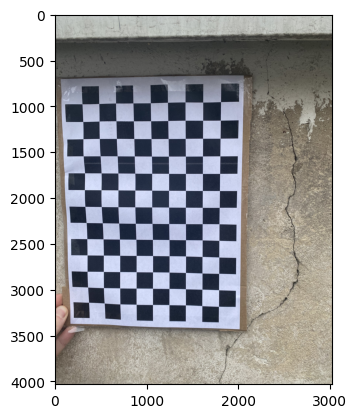

In [ ]:
image_name = "p3"
input_image = cv2.imread("/content/drive/MyDrive/konkurs/real_img/{image_name}.png".format(image_name = image_name))

plt.imshow(colored(input_image))

In [ ]:
input_image = np.asarray(input_image)
input_image.shape

chessboardSize = (9,13)
# read input image
img = copy.deepcopy(input_image)
# convert the input image to a grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chess board corners
ret, corners = cv2.findChessboardCorners(gray, chessboardSize,None)


In [ ]:
for c in corners:
  x = int(c[0][0])
  y = int(c[0][1])
  cv2.circle(img, (x,y), 2, [255,0,255], 30)


In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_COUNT, 40, 0.001)

corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
corners2 = corners

corners_plot = []
for i in corners2:
  x = int(i[0][0])
  y = int(i[0][1])
  corners_plot.append([x,y])

average_px_dist = []
for i in range(len(corners)-1):
  p1x = corners2[i][0][0]
  p1y = corners2[i][0][1]
  p2x = corners2[i+1][0][0]
  p2y = corners2[i+1][0][1]

  p1 = [p1x, p1y]
  p2 = [p2x, p2y]
  dist = calculate_euclidean_distance(p1, p2)
  if dist < 200:
    average_px_dist.append(dist)


object_real_size = 20
object_px_size = sum(average_px_dist) / len(average_px_dist)
px_to_mm = object_px_size / object_real_size

print('''
Rzeczywisty wymiar: {object_real_size} mm
Wymiar na obrazie: {object_px_size} px
Stosunek px/mm: {px_to_mm} px/mm
'''
.format (object_real_size = object_real_size,
         object_px_size = object_px_size,
         px_to_mm = px_to_mm)
)


Rzeczywisty wymiar: 20 mm
Wymiar na obrazie: 182.371066492427 px
Stosunek px/mm: 9.118553324621349 px/mm



In [ ]:
def get_mid_pt(p1, p2):
    x = int((p1[0] + p2[0])/2) - 50
    y = int((p1[1] + p2[1])/2) + 40

    pt = [x,y]
    return pt

img_px = copy.deepcopy(img)
img_mm = copy.deepcopy(img)

plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(colored(img_px))
plt.subplot(122)
plt.imshow(colored(img_mm))

## Measure crack

(4032, 3024, 1)


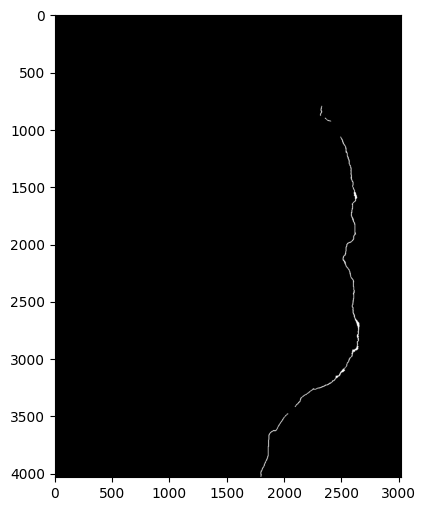

In [ ]:
mask_name = "/content/drive/MyDrive/konkurs/real_mask/{image_name}_label_ground-truth_semantic_colored.png".format(image_name = image_name)
mask_names = [mask_name]

labeled_set = []
for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        labeled_set.append(np.array(image))

#normalize masks, rescale to 0 to 1.
labeled_set = np.expand_dims((np.array(labeled_set)),3) / 255

image_to_measure = labeled_set[0]
print(image_to_measure.shape)

plt.figure(figsize=(6, 6))
plt.imshow(np.reshape(labeled_set[0], (image_to_measure.shape[0],image_to_measure.shape[1])), cmap='gray')


Real world size: 20 mm
Object size in px: 182.371066492427 px
Px to mm ration: 9.118553324621349 px/mm



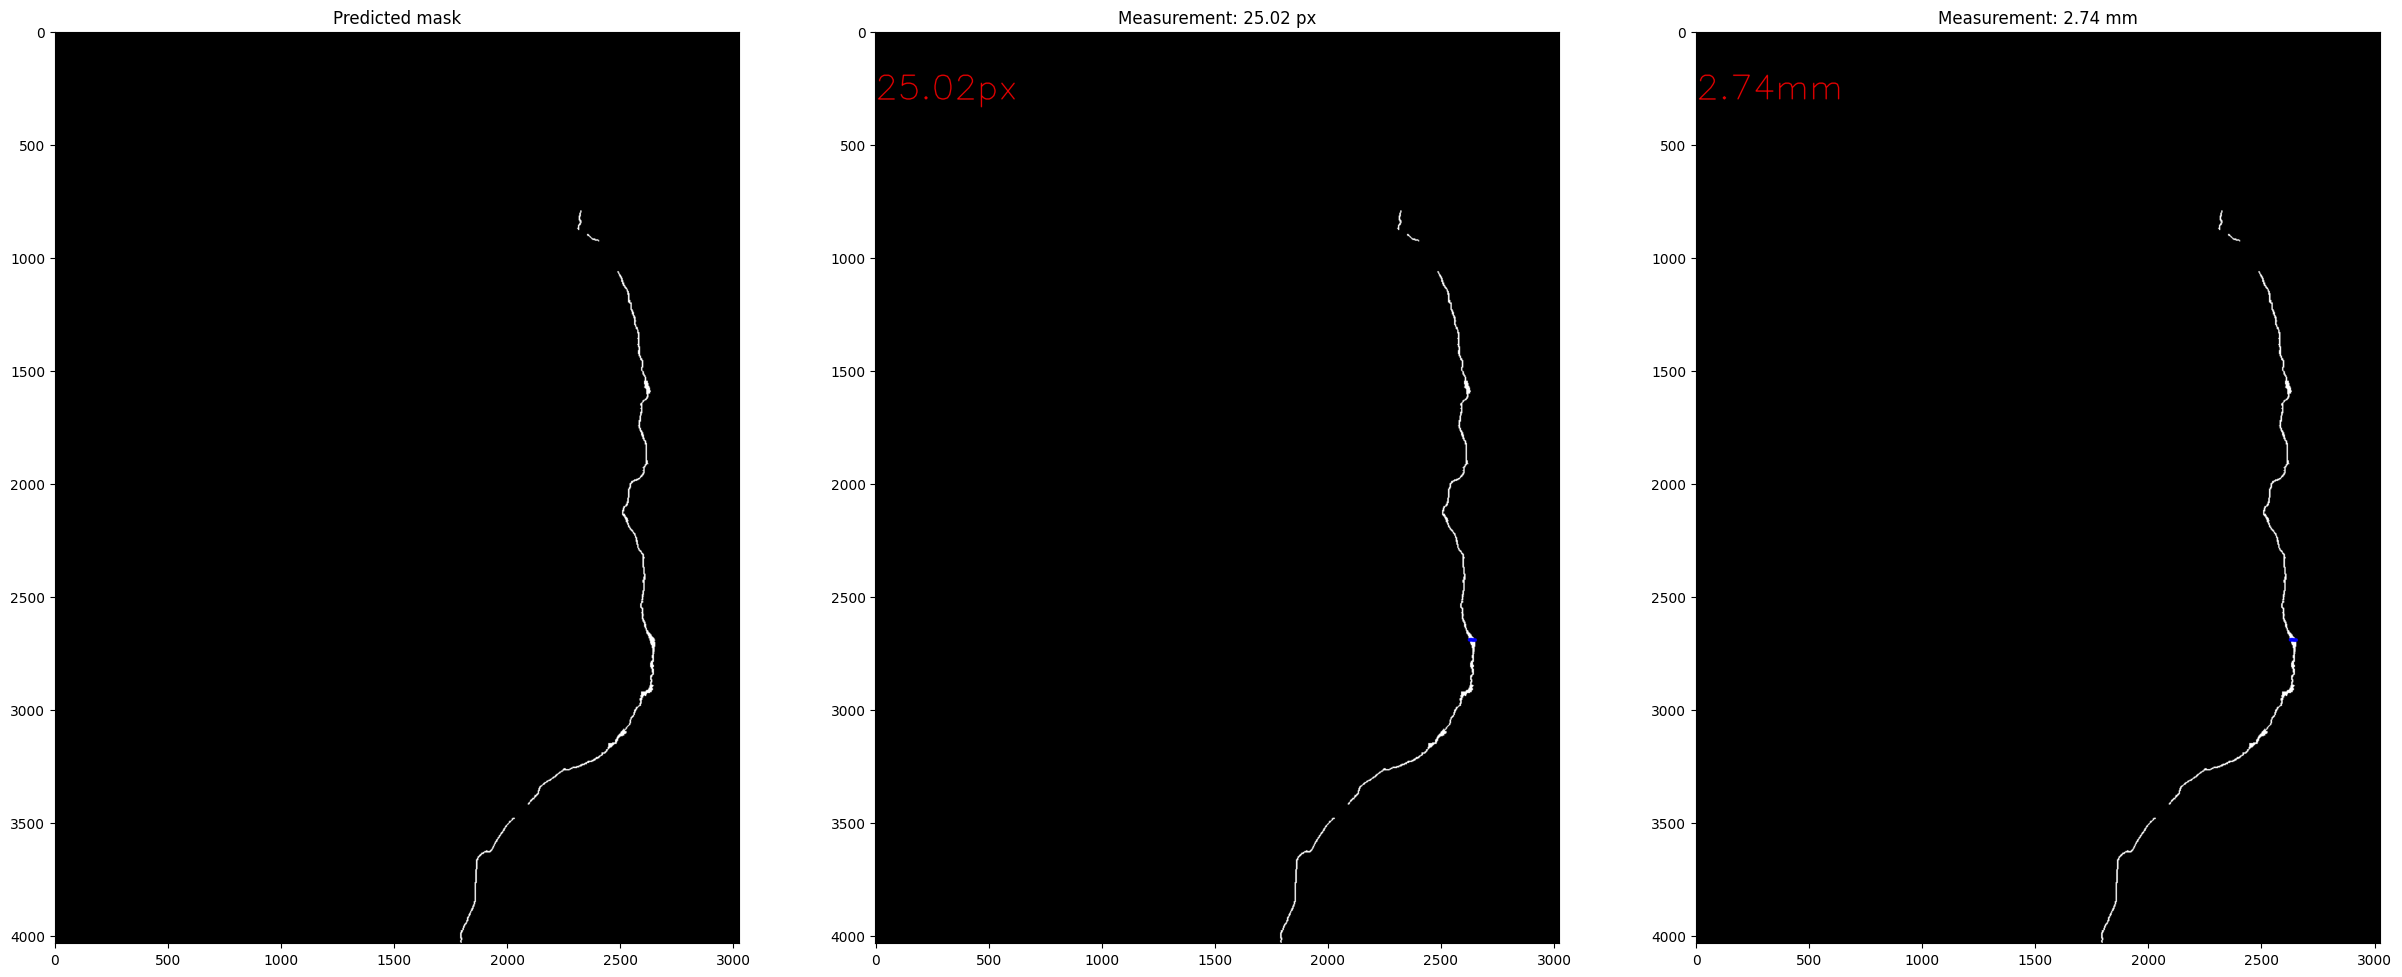

In [ ]:
mask = np.reshape(image_to_measure, (image_to_measure.shape[0],image_to_measure.shape[1])).astype(np.uint8) * 255

#prediction
prediction_measurement_px, predicted_distance_px, prediction_measurement_mm , predicted_distance_mm, c1, c2  = crack_measurement(mask, 500, object_real_size=object_real_size, object_px_size=object_px_size )

print('''
Real world size: {object_real_size} mm
Object size in px: {object_px_size} px
Px to mm ration: {px_to_mm} px/mm
'''
.format (object_real_size = object_real_size,
         object_px_size = object_px_size,
         px_to_mm = px_to_mm)
        )

plt.figure(figsize=(30, 25))
plt.subplot(131)
plt.title('Predicted mask')
plt.imshow(mask, cmap='gray')
plt.subplot(132)
plt.title('Measurement: {value} px'.format(value = round(predicted_distance_px,2)))
plt.imshow(prediction_measurement_px, cmap='gray')
plt.subplot(133)
plt.title('Measurement: {value} mm'.format(value = round(predicted_distance_mm,2)))
plt.imshow(prediction_measurement_mm, cmap='gray')

## Combined results

In [ ]:
results_img = copy.deepcopy(img_mm)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.line(results_img, c1, c2, (0,0, 255,), 15)
cv2.putText(results_img,
            '{predicted_distance_px}px // {predicted_distance_mm}mm'.format(predicted_distance_px = round(predicted_distance_px,2), predicted_distance_mm = round(predicted_distance_mm,2)),
            (0,200),
            cv2.FONT_HERSHEY_SIMPLEX,
            3,
            (0,0,255),
            10,
            cv2.LINE_AA
            )


overlay = image.copy()

# A filled line
cv2.line(overlay, (0,0), (311,211), (0,355,0),40)

# Transparency factor.
alpha = 0.4

# Following line overlays transparent rectangle
# over the image
image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)


plt.figure(figsize=(10, 10))
plt.title('Measurement: {value_px} px // {value_mm} mm'.format(value_px = round(predicted_distance_px,2), value_mm = round(predicted_distance_mm,2)))
plt.imshow(colored(results_img) , cmap='gray')



im = cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB)
PIL_image = Image.fromarray(np.uint8(im)).convert('RGB')
# PIL_image = PIL_image.save("results_img.jpg")

In [ ]:
import tempfile

In [ ]:
def set_image_dpi_resize(image):
    """
    Rescaling image to 300dpi while resizing
    :param image: An image
    :return: A rescaled image
    """
    length_x, width_y = image.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    image_resize = image.resize(size, Image.ANTIALIAS)
    return image_resize


In [ ]:
x = set_image_dpi_resize(PIL_image)

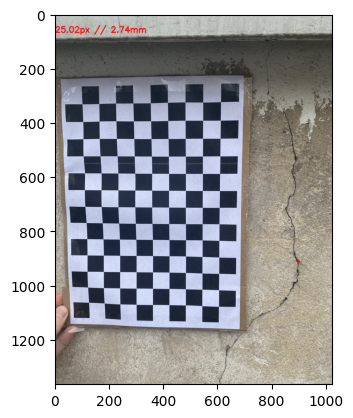

In [ ]:
plt.imshow(x)

In [ ]:
PIL_image = PIL_image.save("results_img_p2.jpg")
PIL_image_300dpi = x.save("results_img_p2_300dpi.jpg")

# test patchify

In [ ]:
mask_names = ["/content/drive/MyDrive/MGR/real_labeled/noCorners_caliResult1_label_ground-truth_semantic_colored.png"]

labeled_set = []
for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        labeled_set.append(np.array(image))

#normalize masks, rescale to 0 to 1.
labeled_set = np.expand_dims((np.array(labeled_set)),3)
image = labeled_set[0]

plt.figure(figsize=(12, 6))
plt.imshow(np.reshape(labeled_set[0], (image.shape[0],image.shape[1])), cmap='gray')

In [ ]:
# splitting the image into patches
image_height, image_width, channel_count = image.shape
patch_height, patch_width, step = 256, 256, 256
patch_shape = (patch_height, patch_width, channel_count)
patches = patchify(image, patch_shape, step=step)
print(patches.shape)

In [ ]:
output_patches = np.empty(patches.shape).astype(np.uint8)
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j, 0]
        #replace process with MEASUREMENT FUCNTION
        # output_patch = process(patch)  # process the patch
        output_patch = patch
        output_patches[i, j, 0] = output_patch

In [ ]:
output_height = image_height - (image_height - patch_height) % step
output_width = image_width - (image_width - patch_width) % step
output_shape = (output_height, output_width, channel_count)
output_image = unpatchify(output_patches, output_shape)
output_image = Image.fromarray(output_image)

In [ ]:
plt.imshow(output_image)